# Exploring QVEC

I want to spend some time now looking closer at QVEC's output, namely the correlations and the alignment matrix. The second main point of the original paper is that the alignments allow you to interpret individual dimensions of embeddings.

In [3]:
%matplotlib inline
import os
import csv
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

data_path = '../../data'
tmp_path = '../../tmp'

### Linguistic features

In [37]:
feature_path = os.path.join(data_path, 'evaluation/semcor/tsvetkov_semcor.csv')
subset = pd.read_csv(feature_path, index_col=0)
subset.columns = [c.replace('semcor.', '') for c in subset.columns]
subset.set_index('words', inplace=True)
subset = subset.T

### Learnt embeddings

In [38]:
size = 300
fname = 'embeddings/glove.6B.{}d.txt'.format(size)
embedding_path = os.path.join(data_path, fname)
embeddings = pd.read_csv(embedding_path, sep=' ', header=None, index_col=0, quoting=csv.QUOTE_NONE).T

### QVEC model

In [53]:
def qvec(features, embeddings):
    """
    Returns correlations between columns of `features` and `embeddings`.
    
    The aligned feature is the one with the highest correlation.
    The qvec score is the sum of correlations of aligned features.
    """
    common_words = embeddings.columns.intersection(features.columns)
    S = features[common_words]
    X = embeddings[common_words]
    correlations = pd.DataFrame({i:X.corrwith(S.iloc[i], axis=1) for i in range(len(S))})
    correlations.columns = S.index
    return correlations

In [40]:
correlations = qvec(subset, embeddings)
V = len(embeddings.columns.intersection(subset.columns))

In [22]:
correlations.head()

,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,noun.feeling,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
1,-0.025195,0.103305,0.022804,0.019960,-0.005073,-0.063040,0.001746,-0.044627,0.060426,-0.000629,...,-0.000923,0.032615,-0.059228,0.002191,0.043395,0.016654,-0.000253,0.015861,-0.058195,0.027505
2,0.025052,0.003521,0.071996,0.033976,0.046986,0.000275,-0.025890,-0.093323,0.013002,-0.026363,...,0.041451,0.004752,0.008058,-0.024316,-0.043428,0.021968,-0.003188,0.024070,0.064498,-0.034473
3,0.000335,0.132868,-0.020388,-0.043322,0.026484,-0.031252,0.051305,0.025105,0.069223,0.112211,...,-0.009357,-0.078781,-0.096304,-0.000102,-0.010545,-0.015110,-0.082116,-0.047947,-0.098220,0.008797
4,0.003880,0.020326,0.023546,-0.164084,-0.013492,-0.079157,0.008527,0.045884,-0.002118,-0.003778,...,0.031046,-0.015342,-0.029799,0.009851,0.045801,-0.023565,0.036102,0.003050,0.059049,-0.009769
5,0.011347,0.032593,0.008034,-0.031921,-0.015440,0.030811,0.026431,-0.020380,-0.054214,0.032733,...,-0.006414,-0.024326,-0.012067,0.045959,-0.026189,-0.051913,0.013840,-0.012455,0.000732,-0.006095


#### On average, how correlated are the dimensions with the linguistic features?

This plot suggests "not really". In fact it looks very normal. That is, on average there is **no** correlation between the dimensions of a word embedding and linguistic features.

This plot isn't that interesting. It's telling me the average of 40 numbers is normally distributed, which comes from CLT.

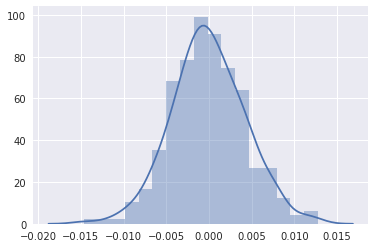

In [41]:
sns.distplot(correlations.mean(axis=1));

#### How correlated are the features and learnt dimensions?

This is a more meaningful plot. It says that the correlations are normally distributed around 0.

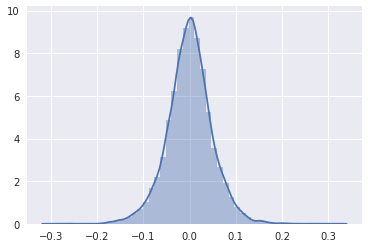

In [42]:
sns.distplot(correlations.values.flatten());

The following summary shows that the $(41*300)$ correlations are centered at 0 with std 0.05. The largest is 0.32, and the smallest is 0.30. These don't seem like very high numbers. The 75% percentile is 0.03. By looking back at the histogram above, it's obviously these dimensions are not highly correlated with these linguistic features.

Another important point from this is that the distribution of correlations is symmetric. So using the the max, rather than the max absolute, seems arbitrary. It doesn't allow for reversed dimensions.

In [43]:
pd.Series(correlations.values.flatten()).describe()

count    12300.000000
mean        -0.000063
std          0.048710
min         -0.298277
25%         -0.028078
50%          0.000444
75%          0.028427
max          0.318956
dtype: float64

#### What do the maximum correlations look like?

These are all positive. But are they different enough from 0? What test can I use here?

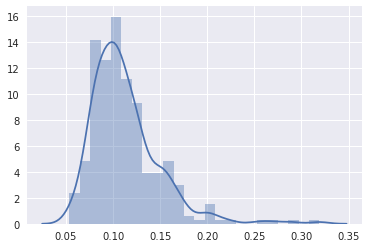

In [45]:
sns.distplot(correlations.max(axis=1));

In [30]:
def test(r, N):
    """"""
    return r / (np.sqrt((1-r**2)/(N-2)))

In [47]:
test(0.3, V)

20.342128644814871

In [ ]:
stats.t()

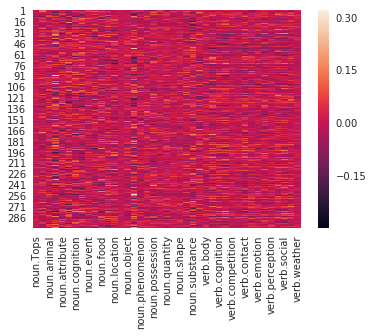

In [29]:
sns.heatmap(correlations);

#### What dimensions and features are aligned?

The dataframe below is as follows: index is the dimension of the learnt embedding, 'feature' is the name of the linguistic feature aligned with that dimension, 'position' is the position of the feature in the feature matrix, and 'max_corr' is the correlation between the dimension and feature.

In [100]:
alignments = pd.DataFrame(correlations.idxmax(axis=1))
alignments.columns = ['feature']
alignments['position'] = alignments['feature'].apply(lambda x: subset.index.get_loc(x))
alignments['max_corr'] = correlations.max(axis=1)
alignments

,feature,position,max_corr
1,noun.act,1,0.103305
2,noun.food,10,0.079669
3,noun.act,1,0.132868
4,noun.time,25,0.118316
5,noun.person,15,0.073610
6,verb.stative,39,0.074339
7,verb.possession,37,0.130992
8,verb.stative,39,0.102332
9,verb.change,27,0.135012
10,noun.person,15,0.151002


#### What is QVEC doing?

A consistent observation is that the distribution of the linguistic features are strongly peaked at 0. That is, almost all words have 0 for for most features. Sometimes, there is some mass at 1. This suggests to me that the linguistic features being used are not appropriate.

In [97]:
common_words = embeddings.columns.intersection(subset.columns)
S = subset[common_words]
X = embeddings[common_words]
def plot(i, j):
    """Plot ith dimension of embeddings against feature j."""
    x = X.loc[i]
    s = S.loc[j]
    sns.jointplot(x, s);

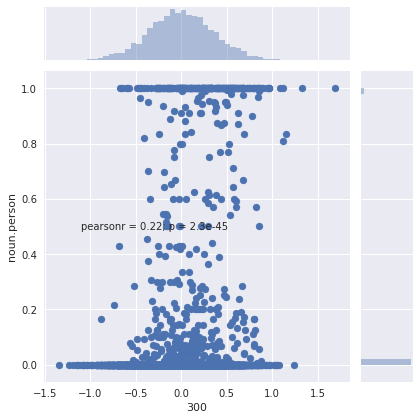

In [101]:
plot(300,'noun.person')

## Todo
- Use different linguistic features (semantic, syntactic, etc.)
- Use different correlation metric
- Explore the correlations, alignments and top k words more
- Levin's verb classification

## Explore correlations, alignments and top k words

#### Top K words
In the paper they give the top K words for a dimension. The code prints, for each dimension, the dimension number, the aligned linguistic feature, the correlation between the two previous things, and the top k words associated with the dimension. I understand the last bit to mean "the k words with the highest value in the dimension".

In [ ]:
k = 50
top_k = pd.DataFrame(alignments, columns=['feature'])
top_k['correlation'] = correlations.max(axis=1)
tmp = pd.DataFrame([embeddings.loc[i].nlargest(n=k).index for i in top_k.index])
top_k = pd.merge(top_k, tmp, left_index=True, right_index=True)

top_k.head()

Most of these top words seem like junk. However, it'd be good to tease this apart a bit more. Here are some questions I'd like to ask:
- Are the top k words even of the right POS?
- Which features are missing (i.e. not the most correlated with any dimension)?
- How can I objectively measure whether the top k words are "correct"?

In [ ]:
def get_dims(feature, df=top_k):
    """Return the dimensions aligned with `feature` in `df`."""
    return df[df['feature']==feature]

get_dims('noun.animal')

#### Which features are not the most correlated with any dimension?

In [ ]:
subset.index.difference(top_k['feature'])

#### FrameNet

- What is the appropriate way to use FrameNet resources as features?

In [ ]:
from nltk.corpus import framenet as fn

fn.lus('happen.v')[1]

tagged_chunks[:20]